# Potato Disease Recognition
This notebook implements a deep learning model for potato disease recognition.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import json

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Configuration parameters
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS = 30
DATASET_PATH = 'Potato_Dataset'

In [3]:
def prepare_data(dataset_path=DATASET_PATH):
    """Prepare and load the dataset"""
    print("Preparing data...")
    
    # Get classes
    classes = [d for d in os.listdir(dataset_path) 
               if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Classes: {classes}")
    
    # Count images in each class
    for cls in classes:
        path = os.path.join(dataset_path, cls)
        if os.path.isdir(path):
            print(f"{cls}: {len(os.listdir(path))} images")
    
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest',
        validation_split=0.2
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    
    # Load training data
    train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    
    # Load validation data
    validation_generator = test_datagen.flow_from_directory(
        dataset_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    print(f"Class indices: {validation_generator.class_indices}")
    return train_generator, validation_generator, classes

In [4]:
def build_transfer_learning_model(num_classes):
    """Build a transfer learning model using MobileNetV2"""
    print("Building transfer learning model with MobileNetV2...")
    
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    return model

In [5]:
def train_model(model, train_generator, validation_generator):
    """Train the model and return history"""
    print(f"Training model for {EPOCHS} epochs...")
    
    # Set up callbacks
    checkpoint = ModelCheckpoint(
        'potato_disease_model_best.keras',  # Changed from .h5 to .keras
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping]
    )
    
    # Save the final model
    model.save('potato_disease_model.keras')  # Changed from .h5 to .keras
    print("Model saved as 'potato_disease_model.keras'")
    
    # Save class indices for later use
    with open('class_indices.json', 'w') as f:
        json.dump(validation_generator.class_indices, f)
    print("Class indices saved as 'class_indices.json'")
    
    return history

In [6]:
def plot_training_history(history):
    """Plot training history graphs"""
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    # Print the final metrics
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

In [7]:
def evaluate_model(model, validation_generator):
    """Evaluate the model on validation data"""
    print("Evaluating model performance...")
    
    # Evaluate the model on the validation set
    validation_generator.reset()
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    # Get true labels
    validation_generator.reset()
    y_true = validation_generator.classes
    
    # Get class names
    class_indices = validation_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}
    
    # Print classification report
    print("\nClassification Report:")
    target_names = [class_names[i] for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return class_indices

In [8]:
def test_on_sample_images(model, dataset_path, class_indices):
    """Test the model on sample images from each class"""
    print("\nTesting model on sample images...")
    
    # Invert class indices to get class names
    class_names = {v: k for k, v in class_indices.items()}
    
    # Get a sample image from each class
    plt.figure(figsize=(15, 10))
    
    for i, class_name in enumerate(class_names.values()):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        # Get a sample image
        sample_images = os.listdir(class_path)[:3]  # Get up to 3 sample images
        
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            
            # Load and preprocess the image
            img = tf.keras.preprocessing.image.load_img(
                img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0
            
            # Make prediction
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions[0])
            confidence = predictions[0][predicted_class]
            
            # Plot the image with prediction
            plt.subplot(len(class_names), 3, i*3 + j + 1)
            plt.imshow(img)
            plt.title(f"True: {class_name}\nPred: {class_names[predicted_class]}\nConf: {confidence:.2f}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.show()

In [9]:
def convert_to_tflite(model):
    """Convert model to TensorFlow Lite format"""
    print("\nConverting model to TensorFlow Lite format...")
    
    # Convert the model to TFLite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    
    # Save the TFLite model
    with open('potato_disease_model.tflite', 'wb') as f:
        f.write(tflite_model)
    
    print("TensorFlow Lite model saved as 'potato_disease_model.tflite'")

In [10]:
def main():
    """Main function to train and test the model"""
    # Prepare data
    train_generator, validation_generator, classes = prepare_data()
    
    # Build model
    model = build_transfer_learning_model(len(classes))
    
    # Train model
    history = train_model(model, train_generator, validation_generator)
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate model
    class_indices = evaluate_model(model, validation_generator)
    
    # Test on sample images
    test_on_sample_images(model, DATASET_PATH, class_indices)
    
    # Convert to TFLite
    convert_to_tflite(model)
    
    print("\nPotato disease recognition model training and evaluation complete!")

Preparing data...
Classes: ['Early Blight', 'Fungi', 'Healthy', 'Late Blight', 'Pest', 'Virus']
Early Blight: 1000 images
Fungi: 748 images
Healthy: 1000 images
Late Blight: 1000 images
Pest: 1000 images
Virus: 1000 images
Found 4599 images belonging to 6 classes.
Found 1149 images belonging to 6 classes.
Class indices: {'Early Blight': 0, 'Fungi': 1, 'Healthy': 2, 'Late Blight': 3, 'Pest': 4, 'Virus': 5}
Building transfer learning model with MobileNetV2...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,918,982 (11.14 MB)

 Trainable params: 659,974 (2.52 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

Training model for 30 epochs...


c:\Users\Adesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6880 - loss: 0.9687
Epoch 1: val_accuracy improved from -inf to 0.78068, saving model to potato_disease_model_best.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.6884 - loss: 0.9670 - val_accuracy: 0.7807 - val_loss: 0.5295
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8066 - loss: 0.4869
Epoch 2: val_accuracy improved from 0.78068 to 0.81549, saving model to potato_disease_model_best.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8066 - loss: 0.4868 - val_accuracy: 0.8155 - val_loss: 0.4421
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8128 - loss: 0.4476  
Epoch 3: val_accuracy improved from 0.81549 to 0.85640, saving model to potato_disease_model_best.keras
144/144 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.8128 - loss: 0.4475 - val_accuracy: 0.8564 - val_loss: 0.3388
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.8438 - loss:

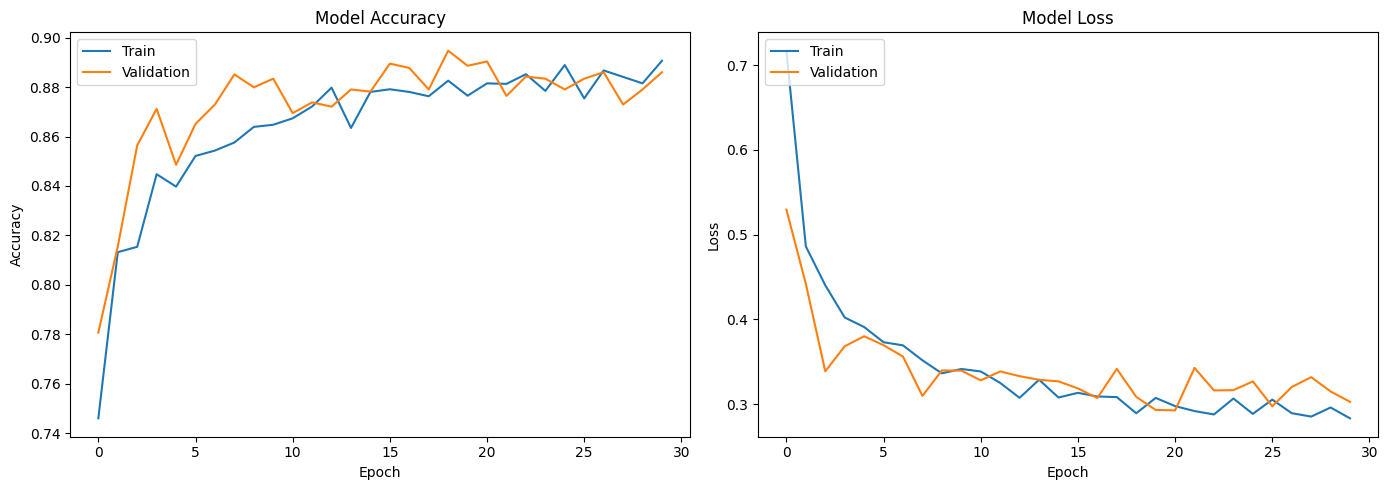

Final Training Accuracy: 0.8906
Final Validation Accuracy: 0.8860
Final Training Loss: 0.2834
Final Validation Loss: 0.3028
Evaluating model performance...
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 636ms/step

Classification Report:
              precision    recall  f1-score   support

Early Blight       1.00      0.98      0.99       200
       Fungi       0.89      0.77      0.82       149
     Healthy       0.92      0.91      0.91       200
 Late Blight       0.92      0.90      0.91       200
        Pest       0.76      0.83      0.80       200
       Virus       0.86      0.92      0.89       200

    accuracy                           0.89      1149
   macro avg       0.89      0.89      0.89      1149
weighted avg       0.89      0.89      0.89      1149



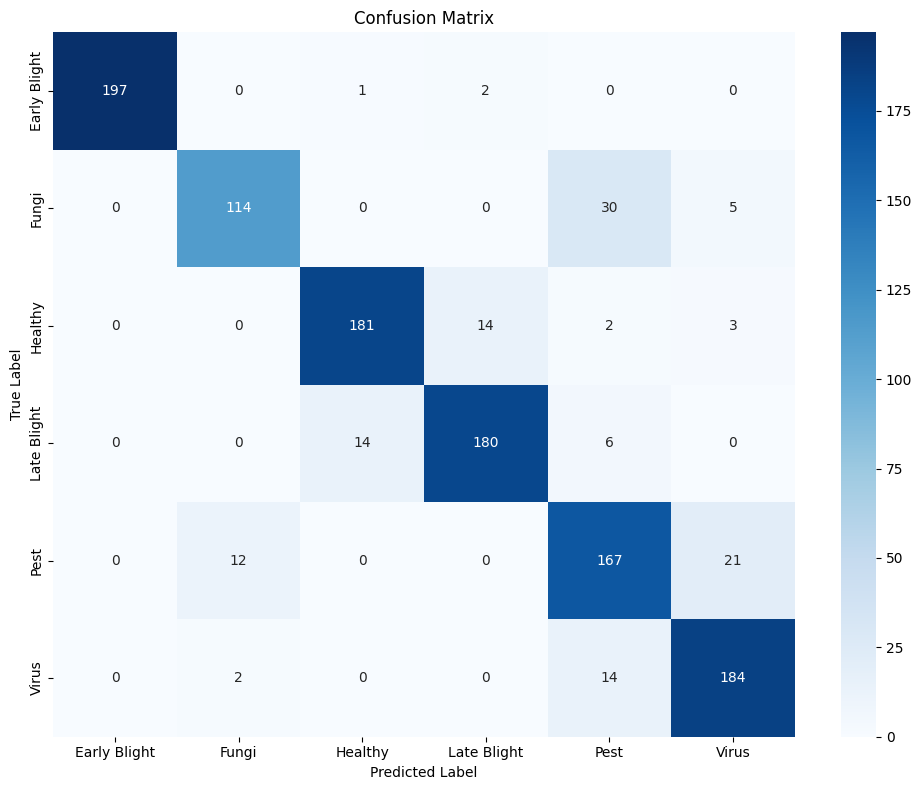


Testing model on sample images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


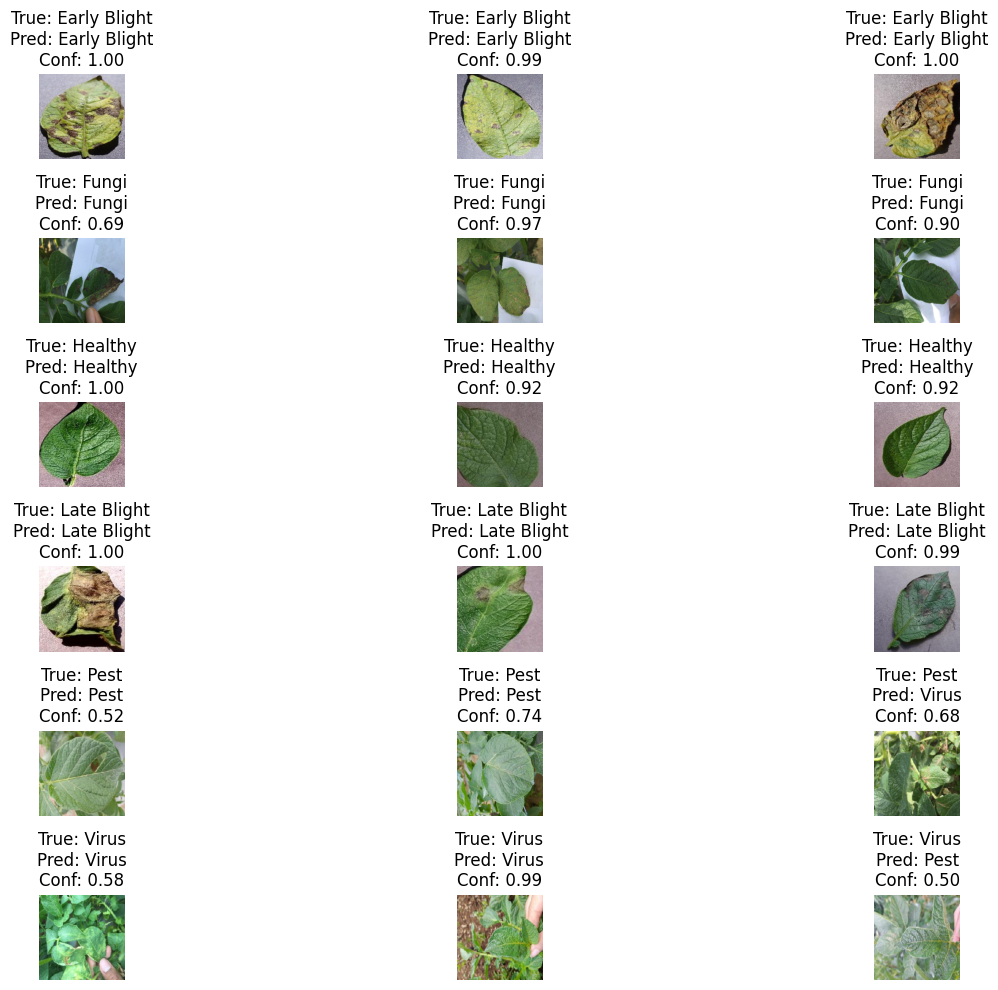


Converting model to TensorFlow Lite format...
INFO:tensorflow:Assets written to: C:\Users\Adesh\AppData\Local\Temp\tmpgkrkjkt1\assets


INFO:tensorflow:Assets written to: C:\Users\Adesh\AppData\Local\Temp\tmpgkrkjkt1\assets


Saved artifact at 'C:\Users\Adesh\AppData\Local\Temp\tmpgkrkjkt1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2042662842288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042754047968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042754049552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042754047792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042754049904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042754053424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042754053072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042754053248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042754054480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2042755777104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

In [11]:
# Run the main function
if __name__ == "__main__":
    main()